In [1]:
import magcolloids as mgc
import os
import sys
import numpy as np
import pandas as pd
import scipy
#from multiprocessing import Pool
#import tqdm.auto as tqdm

sys.path.insert(0, '../icenumerics')

import icenumerics as ice
import matplotlib.pyplot as plt
from matplotlib import patches

# Chirality of each Pentagon

    In this script, we will define a chirality to each pentagon. The total chirality of a pentagon will be computed by the sum of the direction of each spin in the pentagon, +1 (-1) if it is clockwise (counterclockwise). Hence, the expected values for the chirality are +/- 1, +/- 1/5, +/- 3/5.

    First, we will charge the data and try to merge it with the pentagon classification of Pentagon_coordinates_Script-9.2_theta=.dat

In [2]:
data_directory = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts/Output_Script-12.0"

In [3]:
def get_ice_trj(trj,bounds, atom_types = None, trap_types = None):
    """ Converts lammps trj to ice trj
    
    """
    # in the trj dataframe, traps and atoms are labeled by different types. 
    # for single trap type, and single particle type, the default behaviour is to have traps as type 2 and atoms as type 1.
    # If the behaviour is not the default, it should be specified. 
    if trap_types is None:
        trap_types = [2]
       
    try: 
        traps = trj[trj.type.isin(trap_types)].copy(deep=True)
    except TypeError: 
        traps = trj[trj.type.isin([trap_types])].copy(deep=True)
    
    try:
        atoms = trj[trj.type.isin(atom_types)].copy(deep=True)
    except TypeError:
        atoms = trj[trj.type.isin([atom_types])].copy(deep=True)
    
    traps = traps.rename(columns = {"mux":"dx","muy":"dy","muz":"dz"})
    atoms = unwrap_trj(atoms.filter(["x","y","z"]),bounds.loc[[0]])
    
    trj = []
    
    ## It turns out that the traps are not in the same order as the particles, when the system is bidisperse. 
    # we first reindex the traps so that they start at zero, and increase consecutively
    traps_id = traps.index.get_level_values("id").unique()
    reindex_traps = pd.Series({t:i for i, t in enumerate(traps_id)})
    traps.reset_index(inplace = True)
    traps.id = traps.id.map(reindex_traps)
    traps = traps.set_index(["frame","id"]).sort_index()
    
    # we calculate the distance between traps and particles in the first frame,
    # and we build an atom index from the minimization of this distance
    distances = spa.distance.cdist(traps.loc[0,["x","y","z"]], atoms.loc[0,["x","y","z"]])
    reindex_atoms = pd.Series({a+1:t for a, t in enumerate(np.argmin(distances, axis = 0))})
    
    # now we reindex the atoms
    atoms.reset_index(inplace = True)
    atoms.id = atoms.id.map(reindex_atoms)
    atoms = atoms.set_index(["frame","id"]).sort_index()
    
    ## create a relative position vector. This goes from the center of the trap to the position of the particle
    colloids = atoms-traps
    colloids = colloids[["x","y","z"]]
    colloids.columns = ["cx","cy","cz"]
    traps = pd.concat([traps,colloids],axis=1)
    colloids = []
    atoms = []

    ## Flip those traps that are not pointing in the  direction of the colloids
    flip = np.sign((traps[["dx","dy","dz"]].values*traps[["cx","cy","cz"]].values).sum(axis=1))
    traps[["dx","dy","dz"]] = traps[["dx","dy","dz"]].values*flip[:,np.newaxis]

    ## make the direction vector unitary
    mag = np.sign((traps[["dx","dy","dz"]].values**2).sum(axis=1))
    traps[["dx","dy","dz"]] = traps[["dx","dy","dz"]].values*mag[:,np.newaxis]

    #timestep = 10e-3 #sec
    #traps["t"] = traps.index.get_level_values("frame")*timestep

    return traps

In [4]:
load_obj = mgc.trj_lazyread(os.path.join(data_directory,
                                             "ACI_ShaktiLattice_25mT-2500s_FreeBound_l10_exp0.lammpstrj"),
                                                output = ["x","y","z","mux","muy","muz"]) 
    
bnd = load_obj.get_bounds()
trj = load_obj.read_trj()
col_trj = ice.get_ice_trj(trj,bnd, atom_types = 1, trap_types = [3])   

ValueError: cannot handle a non-unique multi-index!

# Try to fix the bug

In [5]:
# First, we will distinguish the long from the short traps. To make the process faster I will filter only the firt frame 
# to do this filter. 
trj0 = trj.loc[0]
atoms = trj0.query('type == 1')

In [6]:
atoms.head(2)

,type,x,y,z,mux,muy,muz
id,,,,,,,
1,1,0.0000,-19.1924,0.0,0.0,0.0,0.0
2,1,-19.1924,28.3848,0.0,0.0,0.0,0.0


In [7]:
trap_l = trj0.query('mux > 20 or mux < -20 or muy > 20 or muy < -20') # filtering long traps
trap_s = trj0.query('mux == 10 or mux == -10 or muy == 10 or muy == -10') #filtering short traps

In [8]:
def new_columns(df):
    '''In this function I'm generating new columns for the particle information '''
    
    df['px'] = np.nan
    df['py'] = np.nan
    df['pz'] = np.nan
    return df 

In [9]:
trap_l = new_columns(trap_l)
trap_s = new_columns(trap_s)

/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/carolina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

I need to build the col_trj dataframe as in the Cairo or other lattices in order to reuse the other functions. 

In [10]:
coord = np.stack((np.ravel(trap_s.x.values), np.ravel(trap_s.y.values)), axis=-1)
coord_atoms = np.stack((np.ravel(atoms.x.values), np.ravel(atoms.y.values)), axis=-1)

In [11]:
KDTree = scipy.spatial.KDTree(coord_atoms)
dist, nn_index = KDTree.query(coord, k=1)

In [14]:
# nn_index is the index of the atom corresponding to 

array([   1,    2,    3,    4,    6,    7,    8,    9,   11,   12,   13,
         14,   16,   17,   18,   19,   21,   22,   23,   24,   26,   27,
         28,   29,   31,   32,   33,   34,   36,   37,   38,   39,   41,
         42,   43,   44,   46,   47,   48,   49,   51,   52,   53,   54,
         56,   57,   58,   59,   61,   62,   63,   64,   66,   67,   68,
         69,   71,   72,   73,   74,   76,   77,   78,   79,   81,   82,
         83,   84,   86,   87,   88,   89,   91,   92,   93,   94,   96,
         97,   98,   99,  101,  102,  103,  104,  106,  107,  108,  109,
        111,  112,  113,  114,  116,  117,  118,  119,  121,  122,  123,
        124,  126,  127,  128,  129,  131,  132,  133,  134,  136,  137,
        138,  139,  141,  142,  143,  144,  146,  147,  148,  149,  151,
        152,  153,  154,  156,  157,  158,  159,  161,  162,  163,  164,
        166,  167,  168,  169,  171,  172,  173,  174,  176,  177,  178,
        179,  181,  182,  183,  184,  186,  187,  1

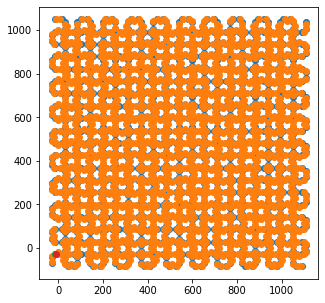

In [21]:
# The KDTree is working.
fig, ax = plt.subplots(1, 1, figsize = (5,5))
plt.plot(trap_s.x, trap_s.y, 'o')
plt.plot(atoms.x, atoms.y, 'o')
plt.plot(trap_s.iloc[2].x, trap_s.iloc[2].y, 'o')
plt.plot(atoms.iloc[3].x, atoms.iloc[3].y, 'o')

Now I need to copy the information of each row to the corresponding trap. 

In [13]:
np.set_printoptions(threshold=np.inf)

In [ ]:
i = 0
for match in nn_index:

    pentagon.iloc[i,6] = col_trj_frame.loc[match].dx
    pentagon.iloc[i,7] = col_trj_frame.loc[match].dy
    pentagon.iloc[i,8] = col_trj_frame.loc[match].dz    
    i = i+1

In [ ]:
i = 0
for match in nn_index:

    pentagon.iloc[i,6] = col_trj_frame.loc[match].dx
    pentagon.iloc[i,7] = col_trj_frame.loc[match].dy
    pentagon.iloc[i,8] = col_trj_frame.loc[match].dz    
    i = i+1

# End tring to fix the bug

In [ ]:
data_directory_1 = "/home/carolina/CairoLattice_ACI_PROJECT/Scripts"

In [ ]:
df = pd.read_csv(os.path.join(data_directory_1,"Pentagon_coordinates_Script-9.2_theta=0.0.dat"), sep = '\t',index_col = [0])

    We will copy the dx, dy, dz values form the col_trj dataframe to the df dataframe to each spin, comparing the coordenates

In [ ]:
df['dx'] = np.NaN
df['dy'] = np.NaN
df['dz'] = np.NaN
df['Chi'] = np.NaN

In [ ]:
def take_trap_pos(col_trj, frame):
    
    """ The following function takes the traps positions of a certain frame from the col_trj dataframe and 
    generates an array with the coordinates """
    
    col_trj_frame = col_trj.loc[frame]
    x = col_trj_frame.x.values
    y = col_trj_frame.y.values
    
    coord = np.stack((np.ravel(x), np.ravel(y)), axis=-1)
    
    return coord, col_trj_frame

In [ ]:
def take_pentagon_coord(df, pentagon):
    
    """ The following function takes one pentagon and put the center positions of the edges in an array of coordinates """
    
    pentagon = df.loc[pentagon]
    x = pentagon.x.values
    y = pentagon.y.values
    
    coord = np.stack((np.ravel(x), np.ravel(y)), axis=-1)
    
    return coord, pentagon

In [ ]:
def take_spin_dir(col_trj, df, frame = int ,pentagon_n = int):
    
    """ This function, pairs the traps in col_trj with the corresponding pentagon of df. After that the dx, dy, dz vectors
    from col_trj are copied next to the corresponfing pentagon position. In order to couple "experimental" directions with 
    the pentagons forming the system """
    
    coord, col_trj_frame = take_trap_pos(col_trj, frame)
    
    coord_p, pentagon = take_pentagon_coord(df, pentagon_n)
    
    KDTree = scipy.spatial.KDTree(coord)
    dist, nn_index = KDTree.query(coord_p, k=1)
    
    i = 0
    for match in nn_index:
        
        pentagon.iloc[i,6] = col_trj_frame.loc[match].dx
        pentagon.iloc[i,7] = col_trj_frame.loc[match].dy
        pentagon.iloc[i,8] = col_trj_frame.loc[match].dz    
        i = i+1
    
    
    return pentagon

In [ ]:
def take_spin_all_pentagons(col_trj, df, frame = int):
    
    """ In this function we will perform the same process as in take_spin_dir() but iterating along all the pentagons
    the output will be a new pentagons dataframe with all the spin information included"""
    
    data = []
    
    for each_pen in np.unique(df.index.values): 
         
        
        data.append(take_spin_dir(col_trj, df, frame = frame, pentagon_n = each_pen))    
   
    pentagons = pd.concat(data)

    return pentagons

    Now I will do some trials in order to understand what I have to do to obtain the chirality values

In [ ]:
def vector_coord( df, col1 = str, col2 = str, col3 = str):
    
    vec_coord = df[[col1, col2, col3]].to_numpy()

    return vec_coord

In [ ]:
def plot_pentagon_and_cross_prod(pentagons, n_pentagon = int):
    
    
    """ The following function, plot the pentagon center, the spins, 
    and the cross product of sigma^spin_direction"""
    
    # < Choose one pentagon >
    first_pen = pentagons.loc[n_pentagon]
    
    sigma = []
    spin = []
    
    # < Compute the cross product >
    for i in range(len(first_pen)):
        row = first_pen.iloc[i]
        
        
        sigma.append(vector_coord( row, col1 = 'dz', col2 = 'dz', col3 = 'z_c'))
        #sigma.append(vector_coord( row, col1 = 'y_c', col2 = 'y_c', col3 = 'z_c'))
        spin.append(vector_coord(row, col1 = 'dx', col2 = 'dy', col3 = 'dz'))
        cross = np.cross(sigma, spin)
        
        
    # < Plot results > 
    fig, ax1 = plt.subplots(figsize=(5,5))
    for index, row in first_pen.iterrows():
    
        ax1.add_patch(patches.Arrow(row.x-row.dx,row.y-row.dy,2*row.dx,2*row.dy,width=5,fc='b'))

    plt.plot(first_pen.x, first_pen.y, 'o', color = 'yellow')
    plt.plot(first_pen.x_c, first_pen.y_c, 'o', color = 'green')
    #plt.plot(first_pen.iloc[0].x, first_pen.iloc[0].y, 'o', markersize = 10, color = 'yellow')


    for i in range(len(first_pen)):

        row = first_pen.iloc[i]
    
        ax1.add_patch(patches.Arrow(first_pen.iloc[i].x,first_pen.iloc[i].y,cross[i,0],cross[i,1],width=5,fc='red'))

    plt.axis('equal')  
    
    return cross

    Now the question is: How we compute de chirality with this vectors?

In [ ]:
def compute_r_vector(pentagons, n_pentagon = int):
    
    r = []
    
    first_pen = pentagons.loc[n_pentagon]
      
    for i in range(len(first_pen)):
            
        row = first_pen.iloc[i]
    
        r.append([row.x-row.x_c, row.y-row.y_c, row.z])
    
    r = np.array(r)
    
    return r

In [ ]:
def chirality_ind_spin(pentagons, cross, n_pentagon = int):
    
    """ This function compute the chirality of each spin in choosen poligon """
    
    cross = plot_pentagon_and_cross_prod(pentagons, n_pentagon)
    r = compute_r_vector(pentagons, n_pentagon)
    chi = []
    
    for i in range(0,5):
        
        chi.append(np.dot(cross[i],r[i])/abs(np.dot(cross[i],r[i])))
        
    Chi = np.sum(chi)/np.sum(np.abs(chi))
    
    first_pen = pentagons.loc[n_pentagon]
    
    first_pen['Chi'] = Chi
    
    
    
    return first_pen
    

In [ ]:
def chirality(pentagons):
   
    df = []
    
    for i in np.unique(pentagons.index.values):
        
        df.append(chirality_ind_spin(pentagons, cross, i))
    
    new_pentagons = pd.concat(df)
        
    return new_pentagons

In [ ]:
pentagons = take_spin_all_pentagons(col_trj, df, frame = 0)

In [ ]:
cross = plot_pentagon_and_cross_prod(pentagons, n_pentagon = 5)
cross

In [ ]:
chirality_ind_spin(pentagons, cross, 9)

In [ ]:
new_pentagons = chirality(pentagons);

In [ ]:
new_pentagons

In [ ]:
#new_pentagons.to_csv('dataframe.dat', sep = '\t')

    Next day I have to code a way to visualize this data and ordering the Script. Maybe I can do an additional support file, a chirality.py file. 
    

In [ ]:
def show_chirality_frame(new_pentagons):
    
    fig, ax = plt.subplots(figsize=(15,15))
    
    for ind, typ in new_pentagons.groupby('pentagon index'):
        
        if (np.unique(typ.Chi)) == 0.2:
            
            ax.add_patch(patches.Circle((np.unique(typ.x_c),np.unique(typ.y_c)),radius = 15,
                    ec='none', fc='red'))
        
        elif (np.unique(typ.Chi)) == -0.2:
            
            ax.add_patch(patches.Circle((np.unique(typ.x_c),np.unique(typ.y_c)),radius = 15,
                    ec='none', fc='blue'))
            
        elif (np.unique(typ.Chi)) == 0.6:
            
            ax.add_patch(patches.Circle((np.unique(typ.x_c),np.unique(typ.y_c)),radius = 15,
                    ec='none', fc='lightcoral'))
            
        elif (np.unique(typ.Chi)) == -0.6:
            
            ax.add_patch(patches.Circle((np.unique(typ.x_c),np.unique(typ.y_c)),radius = 15,
                    ec='none', fc='cornflowerblue'))
            
        elif (np.unique(typ.Chi)) == 1:
            
            ax.add_patch(patches.Circle((np.unique(typ.x_c),np.unique(typ.y_c)),radius = 15,
                    ec='none', fc='limegreen'))
            
        elif (np.unique(typ.Chi)) == -1:
            
            ax.add_patch(patches.Circle((np.unique(typ.x_c),np.unique(typ.y_c)),radius = 15,
                    ec='none', fc='forestgreen'))
    plt.legend()
    plt.xlim(0,800)
    plt.ylim(0,-900)
    plt.axis('equal')
        #print(np.unique(typ.Chi))
        #print(typ.Chi)
        
    from matplotlib.patches import Patch
    from matplotlib.lines import Line2D

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='$\chi$ = + 1/5',
                          markerfacecolor='red', markersize=30),
                   Line2D([0], [0], marker='o', color='w', label='$\chi$ = - 1/5',
                          markerfacecolor='blue', markersize=30),
                   Line2D([0], [0], marker='o', color='w', label='$\chi$ = + 3/5',
                          markerfacecolor='lightcoral', markersize=30),
                  Line2D([0], [0], marker='o', color='w', label='$\chi$ = - 3/5',
                          markerfacecolor='cornflowerblue', markersize=30),
                  Line2D([0], [0], marker='o', color='w', label='$\chi$ = + 1',
                          markerfacecolor='limegreen', markersize=30),
                  Line2D([0], [0], marker='o', color='w', label='$\chi$ = - 1',
                          markerfacecolor='forestgreen', markersize=30),]

# Create the figure
#fig, ax = plt.subplots()
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), fontsize = 30)

    plt.axis('off') 
    
    

In [ ]:
show_chirality_frame(new_pentagons)

In [ ]:
show_chirality_frame(new_pentagons)